In [7]:
# ISA 444 Final Project - Hotel Demand Forecasting

# 1) INSTALLS (safe if rerun)
!pip uninstall -y numpy pandas
!pip install -q numpy pandas==2.2.2 statsforecast utilsforecast mlforecast neuralforecast xgboost lightgbm nixtla holidays

# 2) IMPORTS
import logging
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, AutoETS, AutoARIMA

from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae, rmse, mape
from utilsforecast.plotting import plot_series

from mlforecast import MLForecast
from xgboost import XGBRegressor
import lightgbm as lgb

from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS

from nixtla import NixtlaClient
import holidays

# 3) HOLIDAY HELPER FUNCTIONS
def get_holiday_date(holiday_name: str, year: int, country: str = 'US') -> dt.date:
    """
    Helper to find the calendar date of a given holiday name in a year.
    If not found, returns January 1 as a fallback.
    """
    holiday_map = holidays.country_holidays(country=country, years=[year])
    for d, name in holiday_map.items():
        if name.replace(' (Observed)', '') == holiday_name:
            return d
    return dt.date(year, 1, 1)


def same_day_last_year(
    d: dt.date,
    holiday_adjustment: bool = True,
    shoulder: int = 0,
    country_alpha2_code: str = 'US'
) -> dt.date:
    """
    Map a date to the 'same day last year', with optional holiday adjustment.
    This is included per instructions, but we do NOT use it directly as a
    standalone forecasting method for occupancy.
    """
    # target year, week, and day
    target_year = d.year - 1
    target_week = d.isocalendar()[1]
    target_day_num = d.isocalendar()[2]

    # addressing first day/week of the year issues
    first_day = dt.date(target_year, 1, 1)
    if first_day.isocalendar()[2] > target_day_num:
        target_week += 1

    if not holiday_adjustment:
        # computing target_date
        delta_days = (target_week - 1) * 7 + (target_day_num - first_day.isocalendar()[2])
        target_date = first_day + dt.timedelta(days=delta_days)
        return target_date

    # holiday-aware mapping
    holiday_lst = holidays.country_holidays(
        country=country_alpha2_code,
        years=[d.year - 1, d.year]
    )

    # exact holiday same date
    if d in holiday_lst:
        holiday_name = holiday_lst.get(d).replace(' (Observed)', '')
        target_date = get_holiday_date(holiday_name, d.year - 1, country=country_alpha2_code)
        return target_date

    # shoulder days around holidays
    if shoulder > 0:
        for i in range(-shoulder, shoulder + 1):
            check_date = d + dt.timedelta(days=i)
            if check_date in holiday_lst:
                holiday_name = holiday_lst.get(check_date).replace(' (Observed)', '')
                target_date = get_holiday_date(holiday_name, d.year - 1, country=country_alpha2_code)
                target_date = target_date - dt.timedelta(days=i)
                return target_date

    # default to same week/day mapping
    delta_days = (target_week - 1) * 7 + (target_day_num - first_day.isocalendar()[2])
    target_date = first_day + dt.timedelta(days=delta_days)
    return target_date

# 4) LOAD DATA
hotels = pd.read_parquet(
    "https://github.com/fmegahed/isa444/raw/main/data/sample_hotels.parquet"
)

print("Dataset loaded!")
print("\nDataset info:")
hotels.info()

print("\nNumber of hotels:")
hotel_counts = (
    hotels['unique_id']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'unique_id', 'unique_id': 'count'})
)
display(hotel_counts)

print("\nFirst few rows:")
display(hotels.head())

Found existing installation: numpy 2.3.5
Uninstalling numpy-2.3.5:
  Successfully uninstalled numpy-2.3.5
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lightning 2.4.0 requires packaging<25.0,>=20.0, but you have packaging 25.0 which is incompatible.
tabpfn-time-series 1.0.3 requires pandas<2.2.0,>=2.1.2, but you have pandas 2.2.2 which is incompatible.
timecopilot-timesfm 0.2.1 requires safetensors<0.6,>=0.5.3, but you have safetensors 0.7.0 which is incompatible.
gluonts 0.16.2 requires numpy<2.2,>=1.16, but you have numpy 2.3.5 which is incompatible.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
google-colab 1.0.0 requires tornado==6.5.1, but you have tornado 6.5.2 which is incompatible.
opencv-pyt

W1202 21:33:46.481000 10773 torch/utils/cpp_extension.py:117] No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


Dataset loaded!

Dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 10172 entries, 1430 to 298041
Data columns (total 69 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   unique_id      10172 non-null  object        
 1   ds             10172 non-null  datetime64[us]
 2   holiday_flag   10172 non-null  object        
 3   target_day     10172 non-null  object        
 4   target_month   10172 non-null  object        
 5   target_year    10172 non-null  int32         
 6   location_type  10172 non-null  object        
 7   hotel_type     10172 non-null  object        
 8   y              10172 non-null  float64       
 9   otb_1          10172 non-null  float64       
 10  otb_2          10172 non-null  float64       
 11  otb_3          10172 non-null  float64       
 12  otb_4          10172 non-null  float64       
 13  otb_5          10172 non-null  float64       
 14  otb_6          10172 non-null  float64  

count  count
0     hotel_0    546
1     hotel_7    546
2    hotel_14    546
3    hotel_21    546
4    hotel_28    546
5    hotel_35    546
6    hotel_42    546
7    hotel_49    546
8    hotel_56    546
9    hotel_63    546
10   hotel_70    546
11   hotel_84    546
12   hotel_91    546
13   hotel_98    546
14  hotel_105    546
15  hotel_126    546
16  hotel_112    546
17  hotel_133    546
18   hotel_77    344


First few rows:


unique_id         ds holiday_flag target_day target_month  target_year  \
1430   hotel_0 2022-01-01           no        Sat          Jan         2022   
1431   hotel_0 2022-01-02           no        Sun          Jan         2022   
1432   hotel_0 2022-01-03           no        Mon          Jan         2022   
1433   hotel_0 2022-01-04           no        Tue          Jan         2022   
1434   hotel_0 2022-01-05           no        Wed          Jan         2022   

     location_type              hotel_type         y     otb_1  ...    otb_51  \
1430   NonSuburban  Resorts & Destinations  0.975309  0.679012  ...  0.197531   
1431   NonSuburban  Resorts & Destinations  0.493827  0.308642  ...  0.074074   
1432   NonSuburban  Resorts & Destinations  0.456790  0.358025  ...  0.024691   
1433   NonSuburban  Resorts & Destinations  0.592593  0.419753  ...  0.074074   
1434   NonSuburban  Resorts & Destinations  0.530864  0.407407  ...  0.074074   

        otb_52    otb_53    otb_54    otb_55    otb_56    otb_57    otb_58  \
1430  0.197531  0.197531  0.185185  0.160494  0.160494  0.160494  0.160494   
1431  0.074074  0.074074  0.074074  0.074074  0.061728  0.061728  0.061728   
1432  0.024691  0.024691  0.024691  0.024691  0.024691  0.024691  0.024691   
1433  0.074074  0.074074  0.074074  0.061728  0.061728  0.037037  0.037037   
1434  0.074074  0.074074  0.074074  0.074074  0.049383  0.049383  0.024691   

        otb_59    otb_60  
1430  0.160494  0.160494  
1431  0.061728  0.049383  
1432  0.024691  0.024691  
1433  0.024691  0.024691  
1434  0.024691  0.012346  

[5 rows x 69 columns]

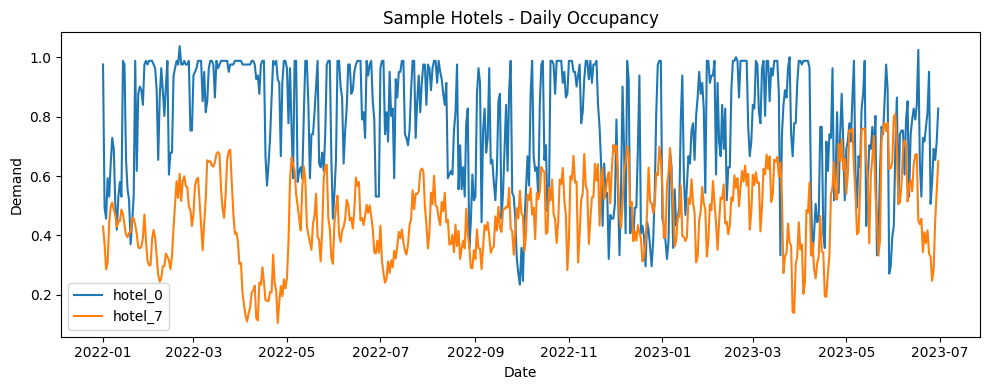

In [8]:
# 5) EXPLORATORY DATA ANALYSIS

_ = plot_series(df=hotels, max_ids=18)
plt.show()

plt.figure(figsize=(10, 4))
first_two_hotels = hotels['unique_id'].unique()[:2]
for h in first_two_hotels:
    tmp = hotels[hotels['unique_id'] == h]
    plt.plot(tmp['ds'], tmp['y'], label=h)
plt.legend()
plt.title("Sample Hotels - Daily Occupancy")
plt.xlabel('Date')
plt.ylabel('Demand')
plt.tight_layout()
plt.show()

In [9]:
# 6) FORECAST SETUP

H = 28
SEASON_LENGTH = 7
N_WINDOWS = 5
STEP_SIZE = H

print("Forecast parameters:")
print(f"  Horizon: {H} days")
print(f"  Season Length: {SEASON_LENGTH}")
print(f"  CV Folds: {N_WINDOWS}")
print(f"  Step Size: {STEP_SIZE} (non-overlapping)")

Forecast parameters:
  Horizon: 28 days
  Season Length: 7
  CV Folds: 5
  Step Size: 28 (non-overlapping)


In [10]:
# 7) STATSFORECAST MODELS + CV
sf_models = [
    Naive(),
    SeasonalNaive(season_length=SEASON_LENGTH, alias='SeasonalNaive'),
    AutoETS(season_length=SEASON_LENGTH, alias='AutoETS'),
    AutoARIMA(season_length=SEASON_LENGTH, alias='AutoARIMA'),
]

sf = StatsForecast(models=sf_models, freq='D')

print("\nRunning StatsForecast cross-validation...")
cv_stats = sf.cross_validation(
    df=hotels[['unique_id', 'ds', 'y']],
    h=H,
    n_windows=N_WINDOWS,
    step_size=STEP_SIZE
)
print("StatsForecast CV completed!")
display(cv_stats.head())

# Evaluate (MAE, RMSE, MAPE)
model_cols_stats = [
    c for c in cv_stats.columns
    if c not in ['unique_id', 'ds', 'cutoff', 'y']
]

stats_metrics = evaluate(
    df=cv_stats,
    metrics=[mae, rmse, mape],
    models=model_cols_stats
).sort_values(['unique_id', 'metric']).reset_index(drop=True)

print("\nStatsForecast Evaluation Metrics:")
display(stats_metrics.head(30))

# Mean Error (ME)
me_results = []
for m in model_cols_stats:
    tmp = cv_stats.copy()
    tmp['error'] = tmp['y'] - tmp[m]
    me_by_hotel = tmp.groupby('unique_id', as_index=False)['error'].mean()
    me_by_hotel.columns = ['unique_id', m]
    me_results.append(me_by_hotel)

me_stats = me_results[0]
for i in range(1, len(me_results)):
    me_stats = me_stats.merge(me_results[i], on='unique_id')

print("\nMean Error (ME) for StatsForecast models:")
display(me_stats.head())

# Best stats model per hotel (by MAE)
stats_mae = stats_metrics.query("metric == 'mae'").reset_index(drop=True)
stats_model_cols = [c for c in stats_mae.columns if c not in ['unique_id', 'metric']]

best_models_stats = []
for _, row in stats_mae.iterrows():
    hotel = row['unique_id']
    sub = row[stats_model_cols]
    best_model = sub.idxmin()
    best_models_stats.append({'unique_id': hotel, 'best_model': best_model})

best_stats_df = pd.DataFrame(best_models_stats)
print("\nBest StatsForecast model per hotel:")
display(best_stats_df)

stats_wins = (
    best_stats_df['best_model']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'model', 'best_model': 'win_count'})
)
print("\nWin counts for StatsForecast models:")
display(stats_wins)



Running StatsForecast cross-validation...
StatsForecast CV completed!


unique_id         ds     cutoff         y     Naive  SeasonalNaive  \
0   hotel_0 2023-02-11 2023-02-10  0.827160  0.691358       0.987654   
1   hotel_0 2023-02-12 2023-02-10  0.518519  0.691358       0.604938   
2   hotel_0 2023-02-13 2023-02-10  0.629630  0.691358       0.913580   
3   hotel_0 2023-02-14 2023-02-10  0.629630  0.691358       0.716049   
4   hotel_0 2023-02-15 2023-02-10  0.888889  0.691358       0.666667   

    AutoETS  AutoARIMA  
0  0.798058   0.777053  
1  0.592257   0.612408  
2  0.611757   0.798756  
3  0.625062   0.785560  
4  0.616607   0.793339


StatsForecast Evaluation Metrics:


unique_id metric     Naive  SeasonalNaive   AutoETS  AutoARIMA
0     hotel_0    mae  0.194709       0.214286  0.184314   0.164152
1     hotel_0   mape  0.341090       0.354191  0.297296   0.283008
2     hotel_0   rmse  0.252434       0.267155  0.223515   0.209060
3   hotel_105    mae  0.120036       0.105301  0.102142   0.098394
4   hotel_105   mape  0.166846       0.122108  0.119321   0.117058
5   hotel_105   rmse  0.159475       0.138870  0.132290   0.118540
6   hotel_112    mae  0.141250       0.113571  0.105768   0.090663
7   hotel_112   mape  0.162640       0.133752  0.122477   0.106771
8   hotel_112   rmse  0.169385       0.139916  0.126474   0.107043
9   hotel_126    mae  0.035515       0.046215  0.061688   0.046029
10  hotel_126   mape  0.041661       0.053137  0.066091   0.051167
11  hotel_126   rmse  0.064730       0.088187  0.080159   0.066724
12  hotel_133    mae  0.107494       0.107260  0.100181   0.112031
13  hotel_133   mape  0.135834       0.136680  0.121159   0.138211
14  hotel_133   rmse  0.143571       0.142579  0.127931   0.144988
15   hotel_14    mae  0.150270       0.118598  0.112286   0.102772
16   hotel_14   mape  0.242134       0.183679  0.174724   0.164183
17   hotel_14   rmse  0.190233       0.157465  0.141631   0.131503
18   hotel_21    mae  0.029993       0.046263  0.031683   0.040868
19   hotel_21   mape  0.033509       0.048704  0.034737   0.043845
20   hotel_21   rmse  0.052660       0.077383  0.049827   0.054523
21   hotel_28    mae  0.008810       0.008810  0.017970   0.009569
22   hotel_28   mape  1.000000       1.000000  0.719383   1.010062
23   hotel_28   rmse  0.063371       0.063371  0.064992   0.063392
24   hotel_35    mae  0.166476       0.168234  0.147365   0.185036
25   hotel_35   mape  0.221173       0.237425  0.198945   0.242343
26   hotel_35   rmse  0.199086       0.198108  0.177570   0.237491
27   hotel_42    mae  0.282562       0.291700  0.270904   0.221071
28   hotel_42   mape  0.480592       0.524014  0.442906   0.419524
29   hotel_42   rmse  0.345949       0.356874  0.323607   0.256775


Mean Error (ME) for StatsForecast models:


unique_id     Naive  SeasonalNaive   AutoETS  AutoARIMA
0    hotel_0 -0.082011      -0.029806  0.007384  -0.052847
1  hotel_105 -0.053190       0.073854  0.062427   0.060943
2  hotel_112  0.064643       0.016429  0.036697   0.015856
3  hotel_126 -0.009562       0.000455  0.037342   0.003115
4  hotel_133 -0.014520       0.017799  0.030077   0.038196


Best StatsForecast model per hotel:


unique_id     best_model
0     hotel_0      AutoARIMA
1   hotel_105      AutoARIMA
2   hotel_112      AutoARIMA
3   hotel_126          Naive
4   hotel_133        AutoETS
5    hotel_14      AutoARIMA
6    hotel_21          Naive
7    hotel_28          Naive
8    hotel_35        AutoETS
9    hotel_42      AutoARIMA
10   hotel_49        AutoETS
11   hotel_56          Naive
12   hotel_63        AutoETS
13    hotel_7      AutoARIMA
14   hotel_70          Naive
15   hotel_77  SeasonalNaive
16   hotel_84      AutoARIMA
17   hotel_91        AutoETS
18   hotel_98      AutoARIMA


Win counts for StatsForecast models:


win_count  count
0      AutoARIMA      8
1          Naive      5
2        AutoETS      5
3  SeasonalNaive      1

In [11]:
# 8) MLFORECAST (XGBoost + LightGBM)

ml_models = {
    'XGBoost': XGBRegressor(
        objective='reg:squarederror',
        n_estimators=200,
        learning_rate=0.1,
        random_state=42,
        verbosity=0
    ),
    'LightGBM': lgb.LGBMRegressor(
        n_estimators=200,
        learning_rate=0.1,
        random_state=42,
        verbosity=-1
    )
}

mlf = MLForecast(
    models=ml_models,
    freq='D',
    lags=[1, 7, 14, 28],
    date_features=['dayofweek', 'day', 'month'],
)

print("\nRunning MLForecast cross-validation...")
cv_ml = mlf.cross_validation(
    df=hotels[['unique_id', 'ds', 'y']],
    h=H,
    n_windows=N_WINDOWS,
    step_size=STEP_SIZE
)
print("MLForecast CV completed!")
display(cv_ml.head())

model_cols_ml = list(ml_models.keys())

ml_metrics = evaluate(
    df=cv_ml,
    metrics=[mae, rmse, mape],
    models=model_cols_ml
).sort_values(['unique_id', 'metric']).reset_index(drop=True)

print("\nMLForecast Evaluation Metrics:")
display(ml_metrics.head(30))

# ME for ML models
me_ml_results = []
for m in model_cols_ml:
    tmp = cv_ml.copy()
    tmp['error'] = tmp['y'] - tmp[m]
    me_by_hotel = tmp.groupby('unique_id', as_index=False)['error'].mean()
    me_by_hotel.columns = ['unique_id', m]
    me_ml_results.append(me_by_hotel)

me_ml = me_ml_results[0]
for i in range(1, len(me_ml_results)):
    me_ml = me_ml.merge(me_ml_results[i], on='unique_id')

print("\nMean Error (ME) for ML models:")
display(me_ml.head())

# Best ML model per hotel
ml_mae = ml_metrics.query("metric == 'mae'").reset_index(drop=True)

best_models_ml = []
for _, row in ml_mae.iterrows():
    hotel = row['unique_id']
    # choose smaller MAE between XGBoost and LightGBM
    best_model = 'XGBoost' if row['XGBoost'] < row['LightGBM'] else 'LightGBM'
    best_models_ml.append({'unique_id': hotel, 'best_model': best_model})

best_ml_df = pd.DataFrame(best_models_ml)
print("\nBest ML model per hotel:")
display(best_ml_df)

ml_wins = (
    best_ml_df['best_model']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'model', 'best_model': 'win_count'})
)
print("\nWin counts for ML models:")
display(ml_wins)



Running MLForecast cross-validation...
MLForecast CV completed!


unique_id         ds     cutoff         y   XGBoost  LightGBM
0   hotel_0 2023-02-11 2023-02-10  0.827160  0.826254  0.842525
1   hotel_0 2023-02-12 2023-02-10  0.518519  0.615302  0.689692
2   hotel_0 2023-02-13 2023-02-10  0.629630  0.688223  0.816837
3   hotel_0 2023-02-14 2023-02-10  0.629630  0.815042  0.849926
4   hotel_0 2023-02-15 2023-02-10  0.888889  0.788566  0.803132


MLForecast Evaluation Metrics:


unique_id metric   XGBoost  LightGBM
0     hotel_0    mae  0.137623  0.127614
1     hotel_0   mape  0.240647  0.223758
2     hotel_0   rmse  0.185493  0.174223
3   hotel_105    mae  0.102500  0.099364
4   hotel_105   mape  0.120654  0.116770
5   hotel_105   rmse  0.130420  0.126229
6   hotel_112    mae  0.107605  0.107282
7   hotel_112   mape  0.126043  0.125624
8   hotel_112   rmse  0.131622  0.131336
9   hotel_126    mae  0.066173  0.060989
10  hotel_126   mape  0.070364  0.065565
11  hotel_126   rmse  0.087910  0.077268
12  hotel_133    mae  0.097793  0.098368
13  hotel_133   mape  0.127322  0.128204
14  hotel_133   rmse  0.131444  0.134982
15   hotel_14    mae  0.096405  0.089324
16   hotel_14   mape  0.155421  0.144340
17   hotel_14   rmse  0.121562  0.113332
18   hotel_21    mae  0.043450  0.043898
19   hotel_21   mape  0.045296  0.045795
20   hotel_21   rmse  0.054955  0.056366
21   hotel_28    mae  0.047241  0.013876
22   hotel_28   mape  0.803794  0.597952
23   hotel_28   rmse  0.110318  0.063131
24   hotel_35    mae  0.097514  0.091505
25   hotel_35   mape  0.145812  0.139736
26   hotel_35   rmse  0.120753  0.118808
27   hotel_42    mae  0.191856  0.184519
28   hotel_42   mape  0.371331  0.376537
29   hotel_42   rmse  0.225436  0.221248


Mean Error (ME) for ML models:


unique_id   XGBoost  LightGBM
0    hotel_0 -0.044760 -0.051527
1  hotel_105  0.053060  0.045387
2  hotel_112  0.038768  0.035616
3  hotel_126  0.047518  0.035808
4  hotel_133  0.017052  0.020961


Best ML model per hotel:


unique_id best_model
0     hotel_0   LightGBM
1   hotel_105   LightGBM
2   hotel_112   LightGBM
3   hotel_126   LightGBM
4   hotel_133    XGBoost
5    hotel_14   LightGBM
6    hotel_21    XGBoost
7    hotel_28   LightGBM
8    hotel_35   LightGBM
9    hotel_42   LightGBM
10   hotel_49   LightGBM
11   hotel_56    XGBoost
12   hotel_63    XGBoost
13    hotel_7    XGBoost
14   hotel_70   LightGBM
15   hotel_77   LightGBM
16   hotel_84    XGBoost
17   hotel_91    XGBoost
18   hotel_98    XGBoost


Win counts for ML models:


win_count  count
0  LightGBM     11
1   XGBoost      8

In [12]:
# 9) NEURALFORECAST (NBEATS + NHITS)
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

nf_models = [
    NBEATS(h=H, input_size=7*4, max_steps=500, alias='NBEATS'),
    NHITS(h=H, input_size=7*4, max_steps=500, alias='NHITS'),
]

nf = NeuralForecast(models=nf_models, freq='D')

print("\nRunning NeuralForecast cross-validation (this may take a bit)...")
cv_nf = nf.cross_validation(
    df=hotels[['unique_id', 'ds', 'y']],
    h=H,
    step_size=STEP_SIZE,
    n_windows=N_WINDOWS
)
print("NeuralForecast CV completed!")
display(cv_nf.head())

model_cols_nf = ['NBEATS', 'NHITS']

nf_metrics = evaluate(
    df=cv_nf,
    metrics=[mae, rmse, mape],
    models=model_cols_nf
).sort_values(['unique_id', 'metric']).reset_index(drop=True)

print("\nNeuralForecast Evaluation Metrics:")
display(nf_metrics.head(30))

# ME for neural models
me_nf_results = []
for m in model_cols_nf:
    tmp = cv_nf.copy()
    tmp['error'] = tmp['y'] - tmp[m]
    me_by_hotel = tmp.groupby('unique_id', as_index=False)['error'].mean()
    me_by_hotel.columns = ['unique_id', m]
    me_nf_results.append(me_by_hotel)

me_nf = me_nf_results[0]
for i in range(1, len(me_nf_results)):
    me_nf = me_nf.merge(me_nf_results[i], on='unique_id')

print("\nMean Error (ME) for Neural models:")
display(me_nf.head())

# Best neural model per hotel
nf_mae = nf_metrics.query("metric == 'mae'").reset_index(drop=True)

best_models_nf = []
for _, row in nf_mae.iterrows():
    hotel = row['unique_id']
    best_model = 'NBEATS' if row['NBEATS'] < row['NHITS'] else 'NHITS'
    best_models_nf.append({'unique_id': hotel, 'best_model': best_model})

best_nf_df = pd.DataFrame(best_models_nf)
print("\nBest Neural model per hotel:")
display(best_nf_df)

nf_wins = (
    best_nf_df['best_model']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'model', 'best_model': 'win_count'})
)
print("\nWin counts for Neural models:")
display(nf_wins)

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1



Running NeuralForecast cross-validation (this may take a bit)...


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=500` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=500` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

NeuralForecast CV completed!


unique_id         ds     cutoff    NBEATS     NHITS         y
0   hotel_0 2023-02-11 2023-02-10  0.797900  0.756542  0.827160
1   hotel_0 2023-02-12 2023-02-10  0.571090  0.506615  0.518519
2   hotel_0 2023-02-13 2023-02-10  0.740430  0.667942  0.629630
3   hotel_0 2023-02-14 2023-02-10  0.770626  0.749283  0.629630
4   hotel_0 2023-02-15 2023-02-10  0.855982  0.770696  0.888889


NeuralForecast Evaluation Metrics:


unique_id metric    NBEATS     NHITS
0     hotel_0    mae  0.156201  0.138769
1     hotel_0   mape  0.275796  0.239071
2     hotel_0   rmse  0.205898  0.188285
3   hotel_105    mae  0.092354  0.103514
4   hotel_105   mape  0.108738  0.118977
5   hotel_105   rmse  0.113017  0.131526
6   hotel_112    mae  0.093454  0.096051
7   hotel_112   mape  0.113788  0.119113
8   hotel_112   rmse  0.112014  0.116303
9   hotel_126    mae  0.041279  0.041663
10  hotel_126   mape  0.046506  0.046689
11  hotel_126   rmse  0.066334  0.064922
12  hotel_133    mae  0.094978  0.091708
13  hotel_133   mape  0.124621  0.120950
14  hotel_133   rmse  0.126961  0.126016
15   hotel_14    mae  0.124236  0.107481
16   hotel_14   mape  0.192290  0.167051
17   hotel_14   rmse  0.156310  0.139258
18   hotel_21    mae  0.030822  0.029957
19   hotel_21   mape  0.033514  0.032779
20   hotel_21   rmse  0.046230  0.046550
21   hotel_28    mae  0.011541  0.010807
22   hotel_28   mape  1.280097  1.103231
23   hotel_28   rmse  0.063644  0.063436
24   hotel_35    mae  0.116720  0.114409
25   hotel_35   mape  0.172003  0.165658
26   hotel_35   rmse  0.148392  0.145070
27   hotel_42    mae  0.213809  0.197011
28   hotel_42   mape  0.451956  0.382457
29   hotel_42   rmse  0.260002  0.234376


Mean Error (ME) for Neural models:


unique_id    NBEATS     NHITS
0    hotel_0 -0.110853 -0.049772
1  hotel_105  0.042416  0.065719
2  hotel_112 -0.020382 -0.038283
3  hotel_126  0.001785  0.006603
4  hotel_133  0.005502  0.003013


Best Neural model per hotel:


unique_id best_model
0     hotel_0      NHITS
1   hotel_105     NBEATS
2   hotel_112     NBEATS
3   hotel_126     NBEATS
4   hotel_133      NHITS
5    hotel_14      NHITS
6    hotel_21      NHITS
7    hotel_28      NHITS
8    hotel_35      NHITS
9    hotel_42      NHITS
10   hotel_49     NBEATS
11   hotel_56     NBEATS
12   hotel_63      NHITS
13    hotel_7      NHITS
14   hotel_70     NBEATS
15   hotel_77      NHITS
16   hotel_84      NHITS
17   hotel_91      NHITS
18   hotel_98     NBEATS


Win counts for Neural models:


win_count  count
0     NHITS     12
1    NBEATS      7

In [13]:
from timecopilot.models.foundation.chronos import Chronos
print("Chronos import SUCCESS ")

# 10) CHRONOS CROSS-VALIDATION

import pandas as pd
from timecopilot import TimeCopilotForecaster
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae, rmse, mape

# REQUIRED FORECASTING PARAMETERS (RESTORED)
H = 28           # 28-day forecast horizon
N_WINDOWS = 5    # number of CV folds
STEP_SIZE = 28   # non-overlapping folds

print("\n Running Chronos 5-fold cross-validation...")

# Load dataset
hotels = pd.read_parquet(
    "https://github.com/fmegahed/isa444/raw/main/data/sample_hotels.parquet"
)

# 1) Define Chronos model
tc_models = [
    Chronos(
        repo_id="amazon/chronos-bolt-small",
        alias="chronos"
    )
]

# 2) Initialize forecaster
tcf = TimeCopilotForecaster(models=tc_models)

# 3) Run cross-validation
cv_chronos = tcf.cross_validation(
    df=hotels[["unique_id", "ds", "y"]],
    h=H,
    freq="D",
    n_windows=N_WINDOWS,
    step_size=STEP_SIZE
)

print("Chronos CV Completed ✔")
display(cv_chronos.head())

# 4) Evaluation metrics
chronos_metrics = (
    evaluate(
        df=cv_chronos,
        metrics=[mae, rmse, mape],
        models=["chronos"]
    )
    .sort_values(["unique_id", "metric"])
    .reset_index(drop=True)
)

print("\n Chronos Evaluation Metrics:")
display(chronos_metrics.head())

# 5) Mean Error (ME)
cv_chronos["error"] = cv_chronos["y"] - cv_chronos["chronos"]

me_chronos = (
    cv_chronos
    .groupby("unique_id", as_index=False)["error"]
    .mean()
    .rename(columns={"error": "chronos"})
)

print("\n Chronos Mean Error (ME):")
display(me_chronos.head())

print("\nChronos CV block DONE ✔")


Chronos import SUCCESS 🎉

🚀 Running Chronos 5-fold cross-validation...


0it [00:00, ?it/s]
100%|██████████| 2/2 [00:02<00:00,  1.36s/it]
1it [00:04,  4.27s/it]
100%|██████████| 2/2 [00:02<00:00,  1.44s/it]
2it [00:08,  4.10s/it]
100%|██████████| 2/2 [00:03<00:00,  1.62s/it]
3it [00:12,  4.32s/it]
100%|██████████| 2/2 [00:03<00:00,  1.57s/it]
4it [00:17,  4.41s/it]
100%|██████████| 2/2 [00:03<00:00,  1.70s/it]
5it [00:22,  4.43s/it]

Chronos CV Completed ✔


unique_id         ds     cutoff         y   chronos
0   hotel_0 2023-02-11 2023-02-10  0.827160  0.753906
1   hotel_0 2023-02-12 2023-02-10  0.518519  0.757812
2   hotel_0 2023-02-13 2023-02-10  0.629630  0.761719
3   hotel_0 2023-02-14 2023-02-10  0.629630  0.785156
4   hotel_0 2023-02-15 2023-02-10  0.888889  0.812500


📊 Chronos Evaluation Metrics:


unique_id metric   chronos
0    hotel_0    mae  0.155232
1    hotel_0   mape  0.274512
2    hotel_0   rmse  0.202216
3  hotel_105    mae  0.087700
4  hotel_105   mape  0.109782


📈 Chronos Mean Error (ME):


unique_id   chronos
0    hotel_0 -0.057850
1  hotel_105  0.024941
2  hotel_112 -0.020965
3  hotel_126 -0.000591
4  hotel_133  0.020810


Chronos CV block DONE ✔


In [16]:
# 11) COMBINE ALL METRICS + OVERALL BEST MODEL
all_metrics = pd.concat(
    [stats_metrics, ml_metrics, nf_metrics, chronos_metrics],
    ignore_index=True
)

print("\nCombined metrics from all models:")
display(all_metrics.head(20))

all_me = (
    me_stats
    .merge(me_ml, on='unique_id')
    .merge(me_nf, on='unique_id')
    .merge(me_chronos, on='unique_id')
)

print("\nMean Error (ME) for all models:")
display(all_me.head())

all_mae = all_metrics.query("metric == 'mae'").reset_index(drop=True)
all_model_cols = [c for c in all_mae.columns if c not in ['unique_id', 'metric']]

overall_best = []
for _, row in all_mae.iterrows():
    hotel = row['unique_id']
    sub = row[all_model_cols]
    best_model = sub.idxmin()
    overall_best.append({'unique_id': hotel, 'best_model': best_model})

overall_best_df = pd.DataFrame(overall_best)
print("Best overall model per hotel (by MAE):")
display(overall_best_df)

overall_wins = (
    overall_best_df['best_model']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'model', 'best_model': 'win_count'})
)
print("\nOVERALL MODEL WIN COUNTS:")
display(overall_wins)


Combined metrics from all models:


unique_id metric     Naive  SeasonalNaive   AutoETS  AutoARIMA  XGBoost  \
0     hotel_0    mae  0.194709       0.214286  0.184314   0.164152      NaN   
1     hotel_0   mape  0.341090       0.354191  0.297296   0.283008      NaN   
2     hotel_0   rmse  0.252434       0.267155  0.223515   0.209060      NaN   
3   hotel_105    mae  0.120036       0.105301  0.102142   0.098394      NaN   
4   hotel_105   mape  0.166846       0.122108  0.119321   0.117058      NaN   
5   hotel_105   rmse  0.159475       0.138870  0.132290   0.118540      NaN   
6   hotel_112    mae  0.141250       0.113571  0.105768   0.090663      NaN   
7   hotel_112   mape  0.162640       0.133752  0.122477   0.106771      NaN   
8   hotel_112   rmse  0.169385       0.139916  0.126474   0.107043      NaN   
9   hotel_126    mae  0.035515       0.046215  0.061688   0.046029      NaN   
10  hotel_126   mape  0.041661       0.053137  0.066091   0.051167      NaN   
11  hotel_126   rmse  0.064730       0.088187  0.080159   0.066724      NaN   
12  hotel_133    mae  0.107494       0.107260  0.100181   0.112031      NaN   
13  hotel_133   mape  0.135834       0.136680  0.121159   0.138211      NaN   
14  hotel_133   rmse  0.143571       0.142579  0.127931   0.144988      NaN   
15   hotel_14    mae  0.150270       0.118598  0.112286   0.102772      NaN   
16   hotel_14   mape  0.242134       0.183679  0.174724   0.164183      NaN   
17   hotel_14   rmse  0.190233       0.157465  0.141631   0.131503      NaN   
18   hotel_21    mae  0.029993       0.046263  0.031683   0.040868      NaN   
19   hotel_21   mape  0.033509       0.048704  0.034737   0.043845      NaN   

    LightGBM  NBEATS  NHITS  chronos  
0        NaN     NaN    NaN      NaN  
1        NaN     NaN    NaN      NaN  
2        NaN     NaN    NaN      NaN  
3        NaN     NaN    NaN      NaN  
4        NaN     NaN    NaN      NaN  
5        NaN     NaN    NaN      NaN  
6        NaN     NaN    NaN      NaN  
7        NaN     NaN    NaN      NaN  
8        NaN     NaN    NaN      NaN  
9        NaN     NaN    NaN      NaN  
10       NaN     NaN    NaN      NaN  
11       NaN     NaN    NaN      NaN  
12       NaN     NaN    NaN      NaN  
13       NaN     NaN    NaN      NaN  
14       NaN     NaN    NaN      NaN  
15       NaN     NaN    NaN      NaN  
16       NaN     NaN    NaN      NaN  
17       NaN     NaN    NaN      NaN  
18       NaN     NaN    NaN      NaN  
19       NaN     NaN    NaN      NaN


Mean Error (ME) for all models:


unique_id     Naive  SeasonalNaive   AutoETS  AutoARIMA   XGBoost  \
0    hotel_0 -0.082011      -0.029806  0.007384  -0.052847 -0.044760   
1  hotel_105 -0.053190       0.073854  0.062427   0.060943  0.053060   
2  hotel_112  0.064643       0.016429  0.036697   0.015856  0.038768   
3  hotel_126 -0.009562       0.000455  0.037342   0.003115  0.047518   
4  hotel_133 -0.014520       0.017799  0.030077   0.038196  0.017052   

   LightGBM    NBEATS     NHITS   chronos  
0 -0.051527 -0.110853 -0.049772 -0.057850  
1  0.045387  0.042416  0.065719  0.024941  
2  0.035616 -0.020382 -0.038283 -0.020965  
3  0.035808  0.001785  0.006603 -0.000591  
4  0.020961  0.005502  0.003013  0.020810

Best overall model per hotel (by MAE):


unique_id best_model
0     hotel_0  AutoARIMA
1   hotel_105  AutoARIMA
2   hotel_112  AutoARIMA
3   hotel_126      Naive
4   hotel_133    AutoETS
..        ...        ...
71   hotel_70    chronos
72   hotel_77    chronos
73   hotel_84    chronos
74   hotel_91    chronos
75   hotel_98    chronos

[76 rows x 2 columns]


OVERALL MODEL WIN COUNTS:


win_count  count
0        chronos     19
1          NHITS     12
2       LightGBM     11
3      AutoARIMA      8
4        XGBoost      8
5         NBEATS      7
6          Naive      5
7        AutoETS      5
8  SeasonalNaive      1

In [18]:
# 12) SAVE RESULTS TO CSV
print("Saving results to CSV files")

all_metrics.to_csv('all_cv_metrics.csv', index=False)
all_me.to_csv('all_me_metrics.csv', index=False)
overall_wins.to_csv('overall_model_wins.csv', index=False)
overall_best_df.to_csv('best_model_per_hotel.csv', index=False)

stats_metrics.to_csv('stats_cv_metrics.csv', index=False)
ml_metrics.to_csv('ml_cv_metrics.csv', index=False)
nf_metrics.to_csv('neural_cv_metrics.csv', index=False)
chronos_metrics.to_csv('chronos_cv_metrics.csv', index=False) # Changed from timegpt_metrics

print("Saved: all_cv_metrics.csv, all_me_metrics.csv, overall_model_wins.csv, best_model_per_hotel.csv")
print("Saved: stats_cv_metrics.csv, ml_cv_metrics.csv, neural_cv_metrics.csv, chronos_cv_metrics.csv") # Updated print statement

Saving results to CSV files
Saved: all_cv_metrics.csv, all_me_metrics.csv, overall_model_wins.csv, best_model_per_hotel.csv
Saved: stats_cv_metrics.csv, ml_cv_metrics.csv, neural_cv_metrics.csv, chronos_cv_metrics.csv


In [24]:
# 13) FINAL FORECASTS (Stats, ML, Neural, Chronos)

print("Retraining all models on full data for final 28-day forecasts")

# 1) StatsForecast
sf_full = StatsForecast(models=sf_models, freq='D')
sf_full.fit(hotels[['unique_id', 'ds', 'y']])
fcst_stats = sf_full.predict(h=H)
print("StatsForecast final forecasts done.")

# 2) MLForecast
mlf_full = MLForecast(
    models=ml_models,
    freq='D',
    lags=[1, 7, 14, 28],
    date_features=['dayofweek', 'day', 'month'],
)
mlf_full.fit(hotels[['unique_id', 'ds', 'y']])
fcst_ml = mlf_full.predict(h=H)
print("MLForecast final forecasts done.")

# 3) NeuralForecast
nf_full = NeuralForecast(models=nf_models, freq='D')
nf_full.fit(df=hotels[['unique_id', 'ds', 'y']])
fcst_nf = nf_full.predict()
print("NeuralForecast final forecasts done.")

# 4) Chronos Final Forecasts
chronos_full = TimeCopilotForecaster(models=tc_models)
fcst_chronos = chronos_full.forecast(
    df=hotels[['unique_id', 'ds', 'y']],
    h=H,
    freq='D'
)
print("Chronos final forecasts done.")

# Merge all forecasts together
final_forecasts = fcst_stats.copy()

# ML
final_forecasts = final_forecasts.merge(
    fcst_ml[['unique_id', 'ds'] + model_cols_ml],
    on=['unique_id', 'ds'],
    how='left'
)

# Neural
fcst_nf_reset = fcst_nf.reset_index()
final_forecasts = final_forecasts.merge(
    fcst_nf_reset[['unique_id', 'ds'] + model_cols_nf],
    on=['unique_id', 'ds'],
    how='left'
)

# Chronos
final_forecasts = final_forecasts.merge(
    fcst_chronos[['unique_id', 'ds', 'chronos']],
    on=['unique_id', 'ds'],
    how='left'
)

print("\nFinal forecasts (first 30 rows):")
display(final_forecasts.head(30))

final_forecasts.to_csv('final_forecasts_28days.csv', index=False)
print("Saved: final_forecasts_28days.csv ✔")

Retraining all models on full data for final 28-day forecasts
StatsForecast final forecasts done.


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


MLForecast final forecasts done.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=500` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_steps=500` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=500` reached.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

NeuralForecast final forecasts done.


100%|██████████| 2/2 [00:03<00:00,  1.78s/it]

Chronos final forecasts done.

Final forecasts (first 30 rows):


unique_id         ds    Naive  SeasonalNaive   AutoETS  AutoARIMA  \
0     hotel_0 2023-07-01  0.82716       0.950617  0.854200   0.889500   
1     hotel_0 2023-07-02  0.82716       0.506173  0.625889   0.652559   
2     hotel_0 2023-07-03  0.82716       0.580247  0.646667   0.646426   
3     hotel_0 2023-07-04  0.82716       0.691358  0.683990   0.719156   
4     hotel_0 2023-07-05  0.82716       0.654321  0.681233   0.701672   
5     hotel_0 2023-07-06  0.82716       0.716049  0.718236   0.730407   
6     hotel_0 2023-07-07  0.82716       0.827160  0.822019   0.775989   
7     hotel_0 2023-07-08  0.82716       0.950617  0.854200   0.823872   
8     hotel_0 2023-07-09  0.82716       0.506173  0.625889   0.653873   
9     hotel_0 2023-07-10  0.82716       0.580247  0.646667   0.666946   
10    hotel_0 2023-07-11  0.82716       0.691358  0.683990   0.713621   
11    hotel_0 2023-07-12  0.82716       0.654321  0.681233   0.700137   
12    hotel_0 2023-07-13  0.82716       0.716049  0.718236   0.722270   
13    hotel_0 2023-07-14  0.82716       0.827160  0.822019   0.760162   
14    hotel_0 2023-07-15  0.82716       0.950617  0.854200   0.788731   
15    hotel_0 2023-07-16  0.82716       0.506173  0.625889   0.683983   
16    hotel_0 2023-07-17  0.82716       0.580247  0.646667   0.686991   
17    hotel_0 2023-07-18  0.82716       0.691358  0.683990   0.717330   
18    hotel_0 2023-07-19  0.82716       0.654321  0.681233   0.709291   
19    hotel_0 2023-07-20  0.82716       0.716049  0.718236   0.722488   
20    hotel_0 2023-07-21  0.82716       0.827160  0.822019   0.744336   
21    hotel_0 2023-07-22  0.82716       0.950617  0.854200   0.763605   
22    hotel_0 2023-07-23  0.82716       0.506173  0.625889   0.694104   
23    hotel_0 2023-07-24  0.82716       0.580247  0.646667   0.697794   
24    hotel_0 2023-07-25  0.82716       0.691358  0.683990   0.717393   
25    hotel_0 2023-07-26  0.82716       0.654321  0.681233   0.711969   
26    hotel_0 2023-07-27  0.82716       0.716049  0.718236   0.720873   
27    hotel_0 2023-07-28  0.82716       0.827160  0.822019   0.735873   
28  hotel_105 2023-07-01  1.00000       0.987421  1.047645   0.985824   
29  hotel_105 2023-07-02  1.00000       0.993711  0.961654   0.993718   

     XGBoost  LightGBM    NBEATS     NHITS   chronos  
0   0.930912  0.909990  0.931432  0.904764  0.796875  
1   0.692206  0.685011  0.550312  0.503114  0.671875  
2   0.653122  0.583892  0.600534  0.590019  0.640625  
3   0.728333  0.623491  0.682409  0.698718  0.683594  
4   0.736866  0.672100  0.702272  0.734978  0.742188  
5   0.770352  0.708299  0.677897  0.712007  0.796875  
6   0.816631  0.786009  0.818928  0.820973  0.843750  
7   0.884442  0.881940  0.912402  0.894986  0.863281  
8   0.592709  0.591374  0.536536  0.508745  0.765625  
9   0.664176  0.636226  0.612073  0.607332  0.757812  
10  0.725300  0.675577  0.710326  0.717800  0.800781  
11  0.783706  0.722440  0.721040  0.722298  0.824219  
12  0.817953  0.780827  0.683941  0.700262  0.832031  
13  0.861772  0.837099  0.806110  0.809095  0.847656  
14  0.924563  0.929700  0.903688  0.882830  0.832031  
15  0.630372  0.703898  0.523708  0.491163  0.683594  
16  0.713505  0.691178  0.641857  0.585778  0.644531  
17  0.781754  0.739917  0.760424  0.719338  0.675781  
18  0.817062  0.770091  0.749538  0.724983  0.718750  
19  0.817709  0.771864  0.700403  0.704341  0.765625  
20  0.852988  0.825305  0.849230  0.821432  0.804688  
21  0.914208  0.891437  0.918085  0.902246  0.812500  
22  0.645945  0.653984  0.582722  0.530570  0.703125  
23  0.749430  0.712924  0.605294  0.610279  0.675781  
24  0.782512  0.793598  0.755190  0.712809  0.695312  
25  0.803378  0.808998  0.721509  0.736911  0.722656  
26  0.799768  0.771189  0.709613  0.706607  0.757812  
27  0.899275  0.856540  0.832609  0.814162  0.796875  
28  0.990653  0.997940  1.005333  1.002644  0.996094  
29  1.001431  1.000737  1.003727  1.002491  0.988281

Saved: final_forecasts_28days.csv ✔


Creating forecast plots for all hotels


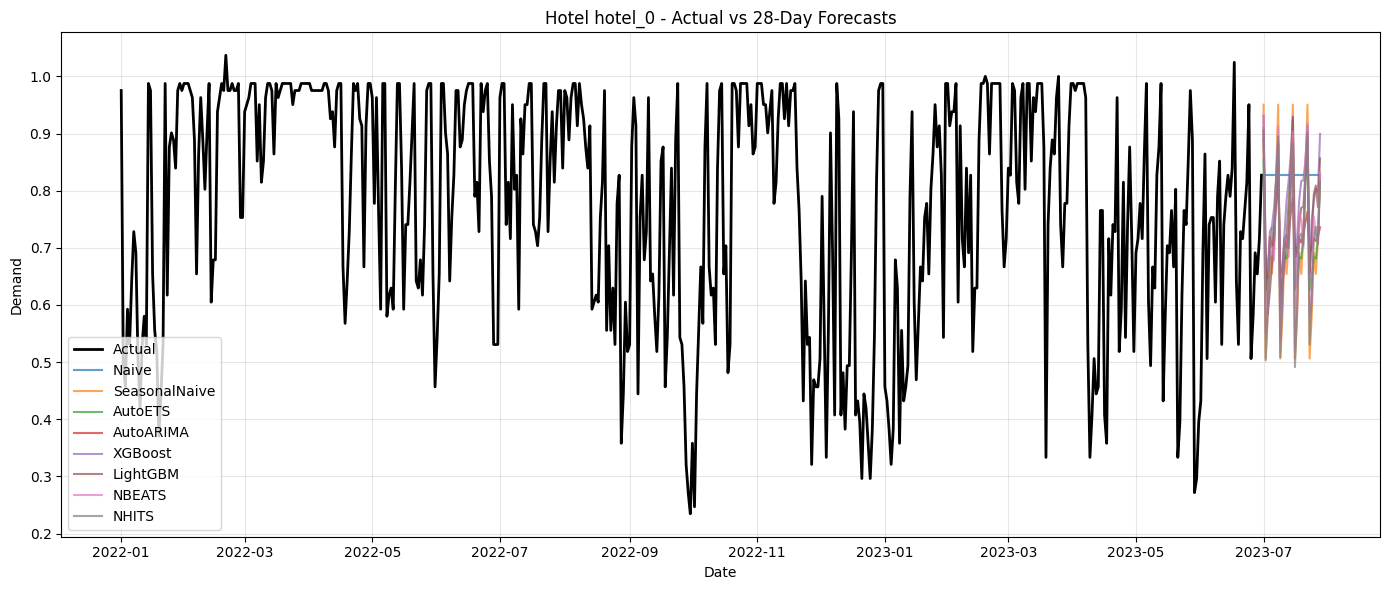

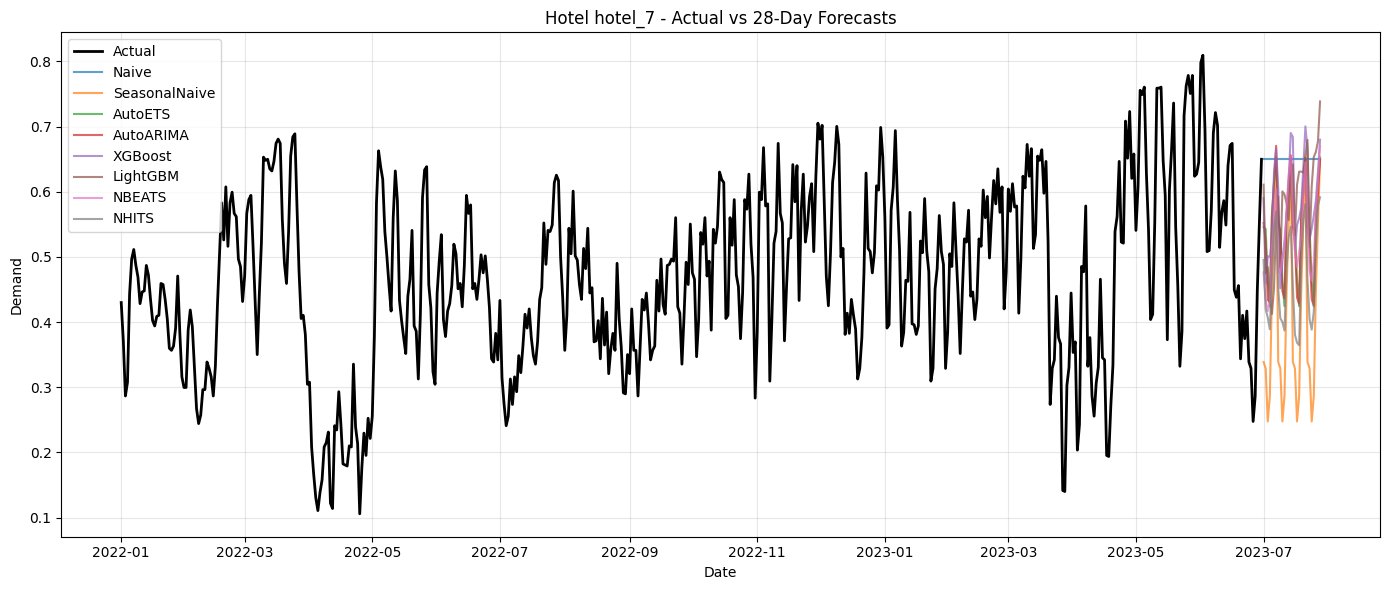

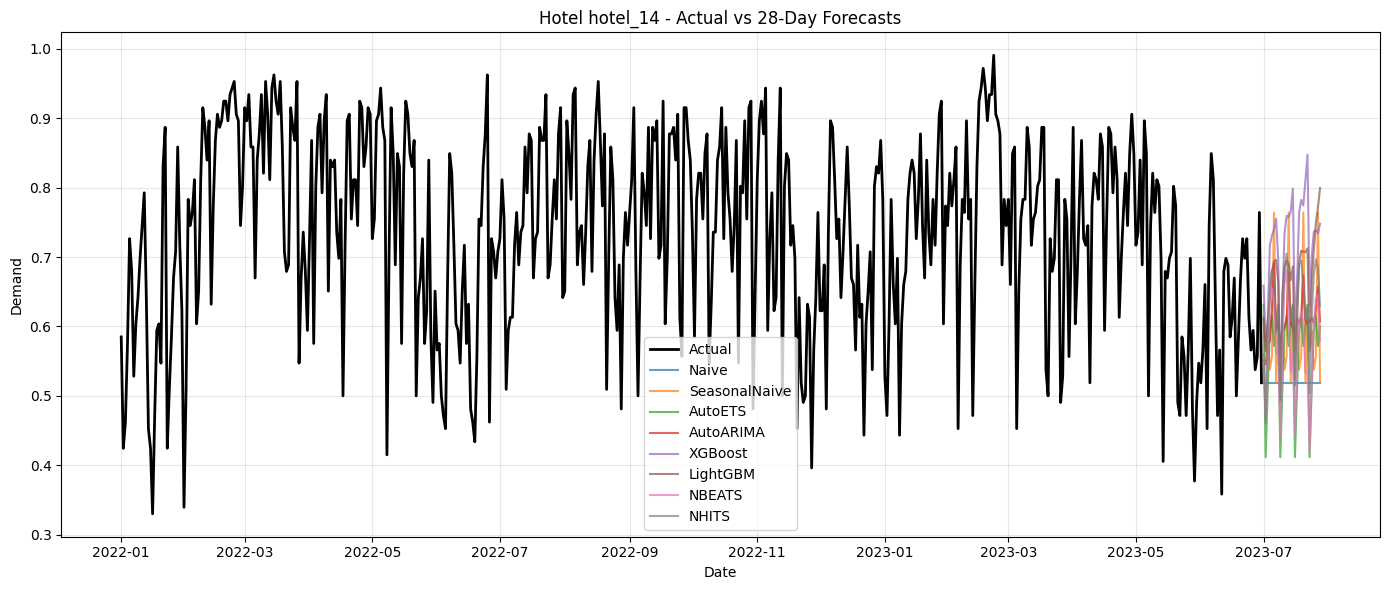

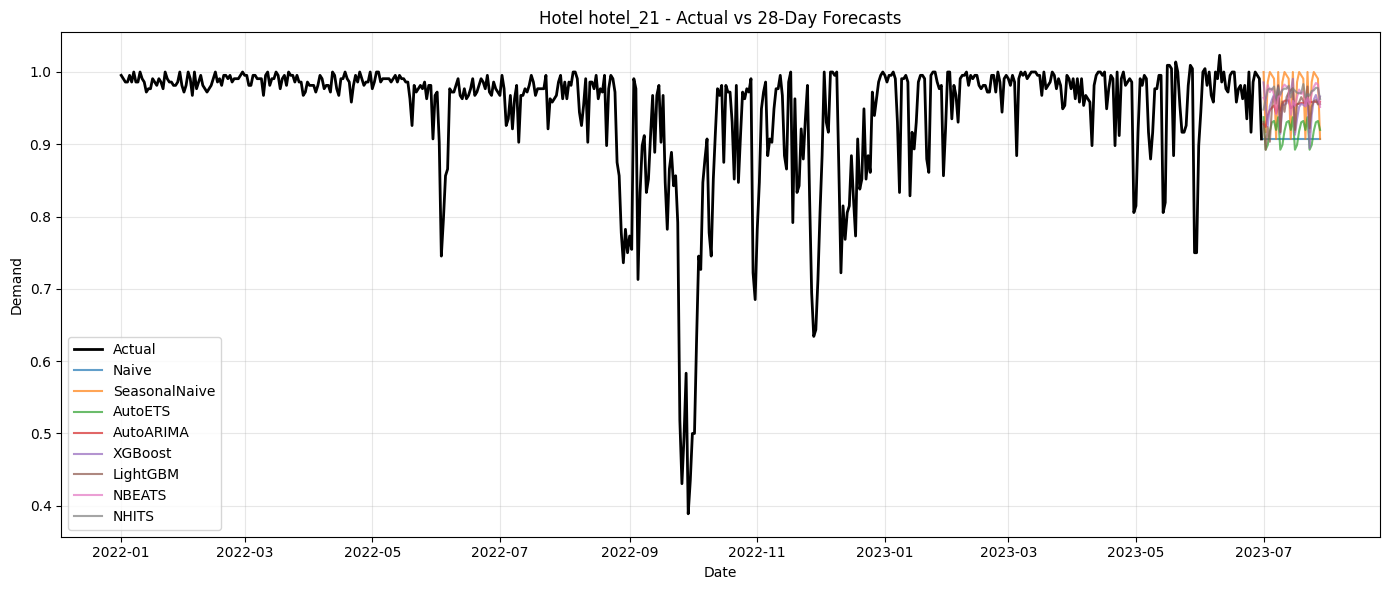

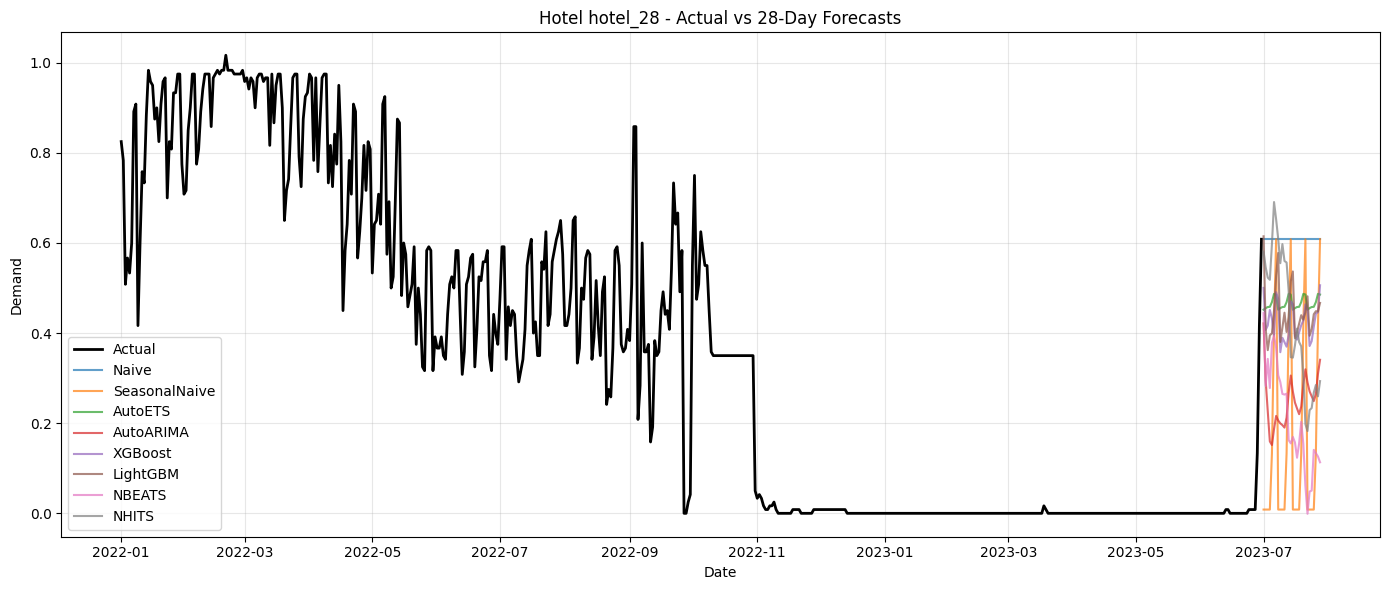

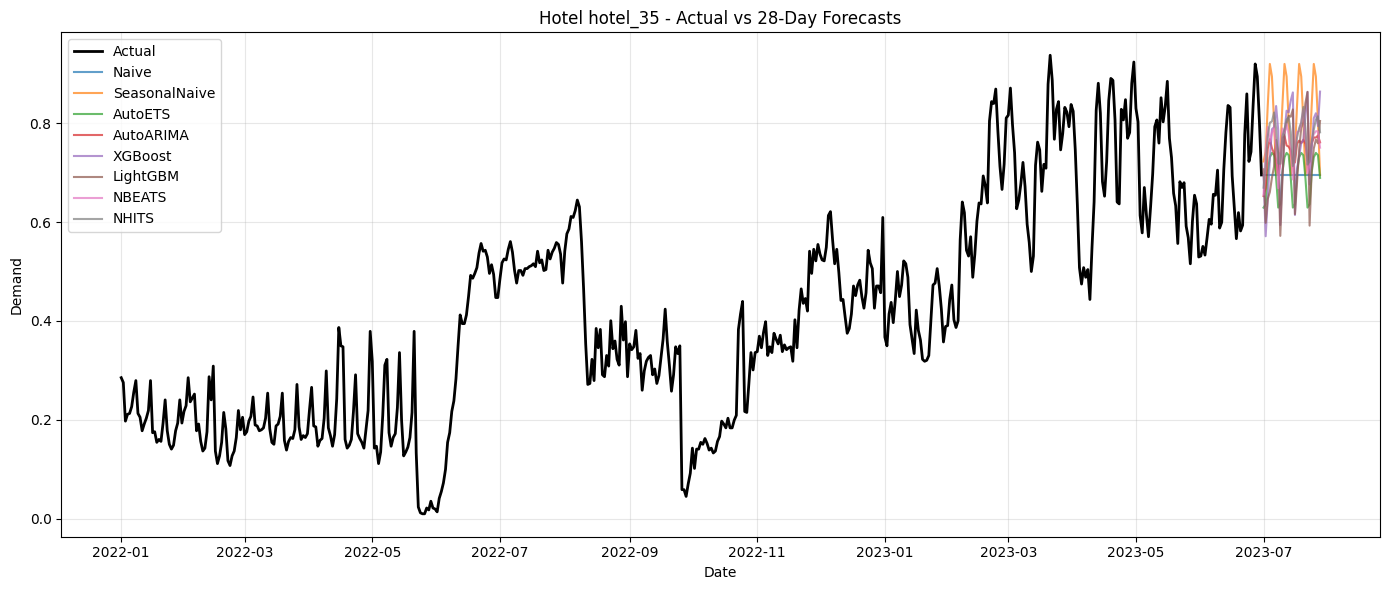

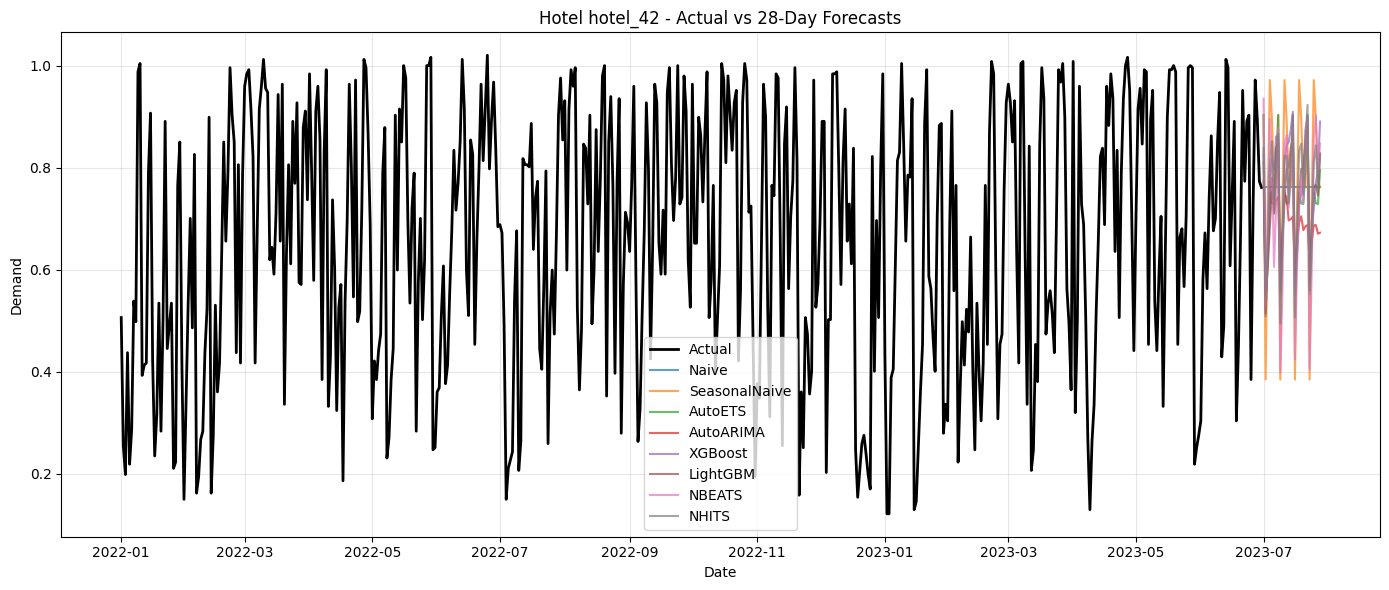

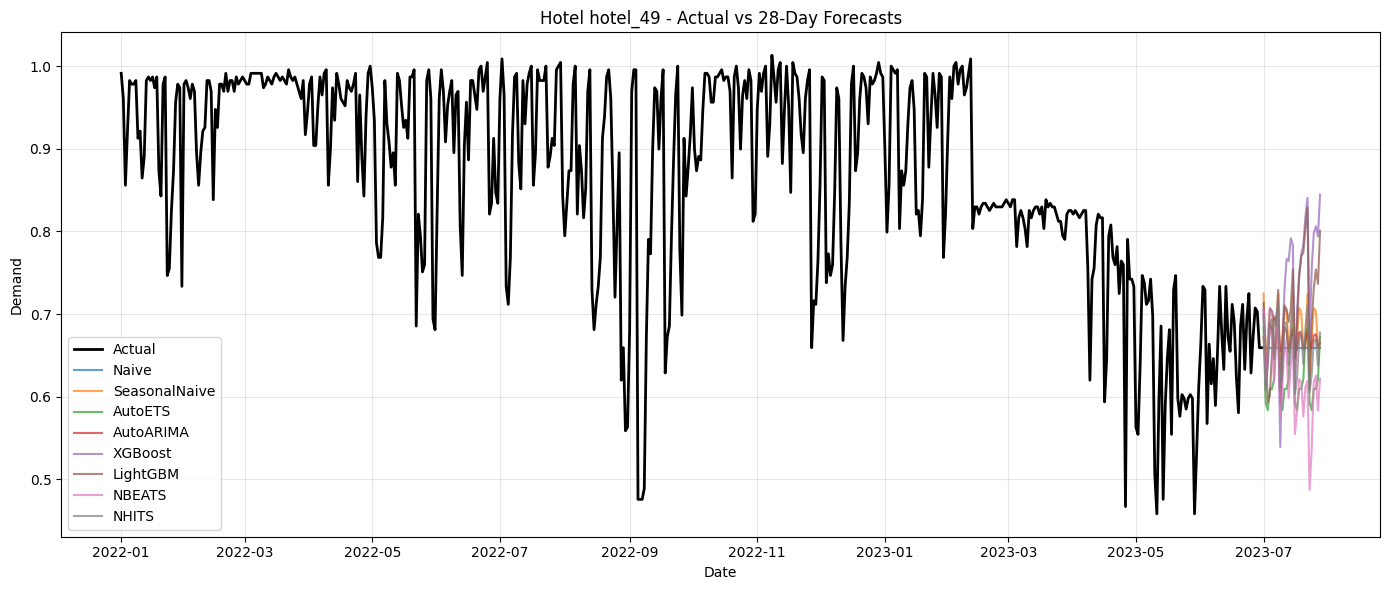

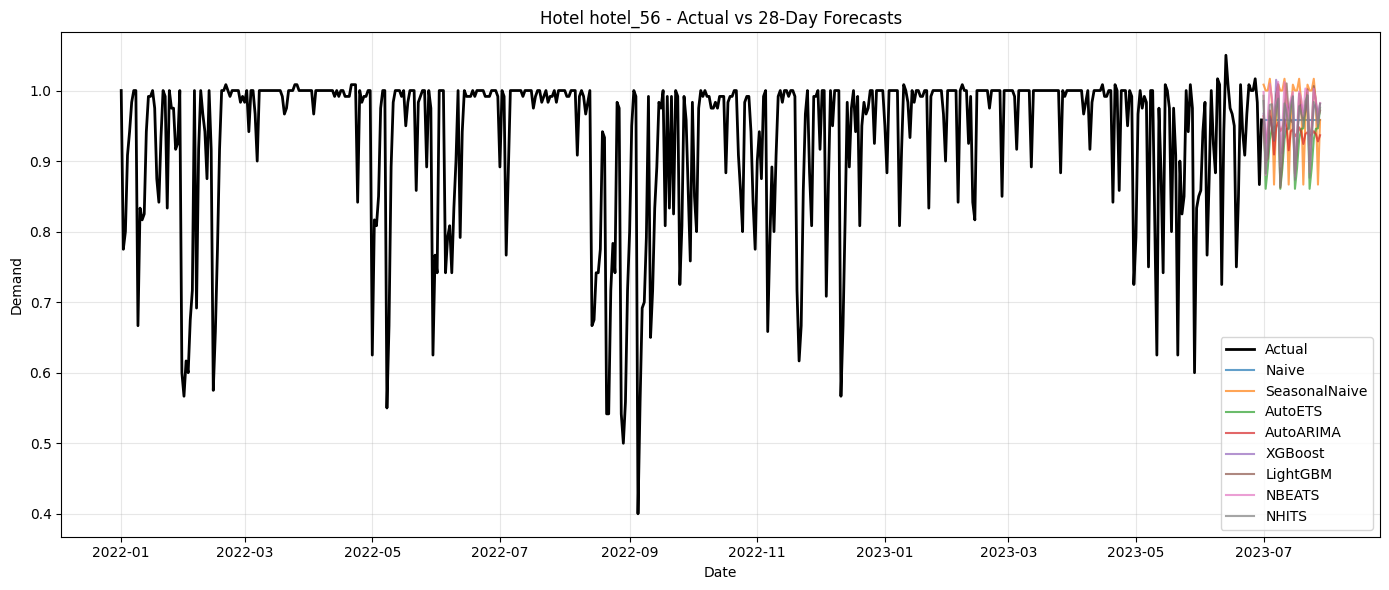

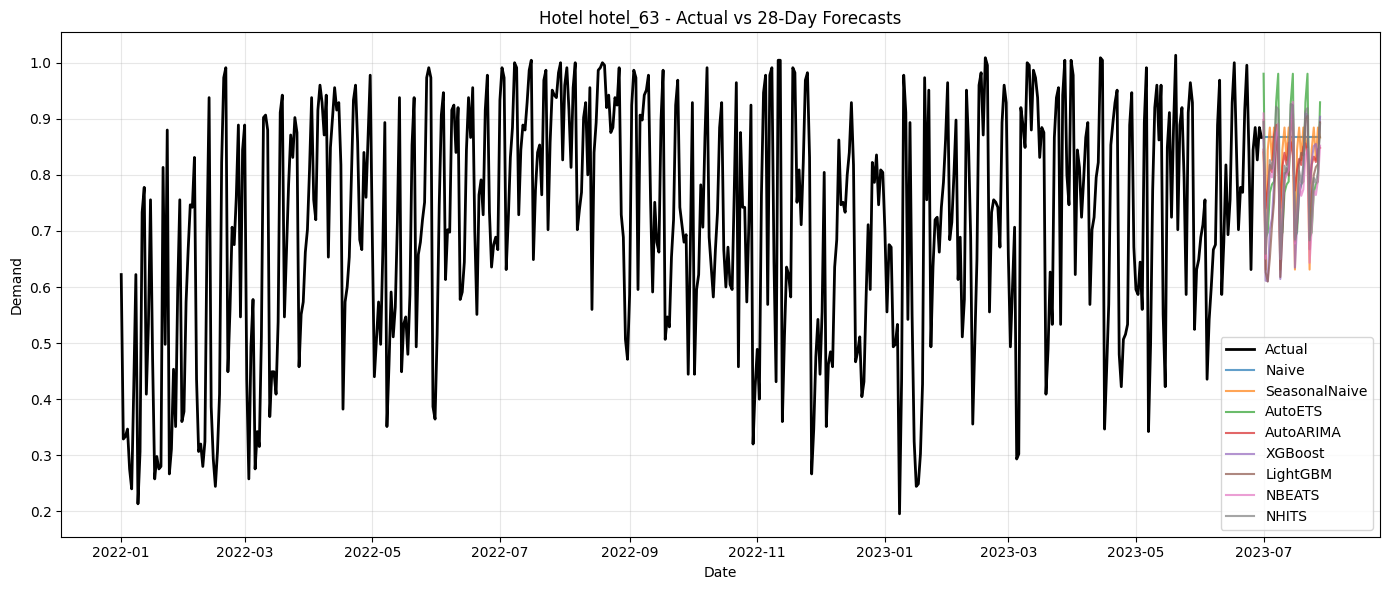

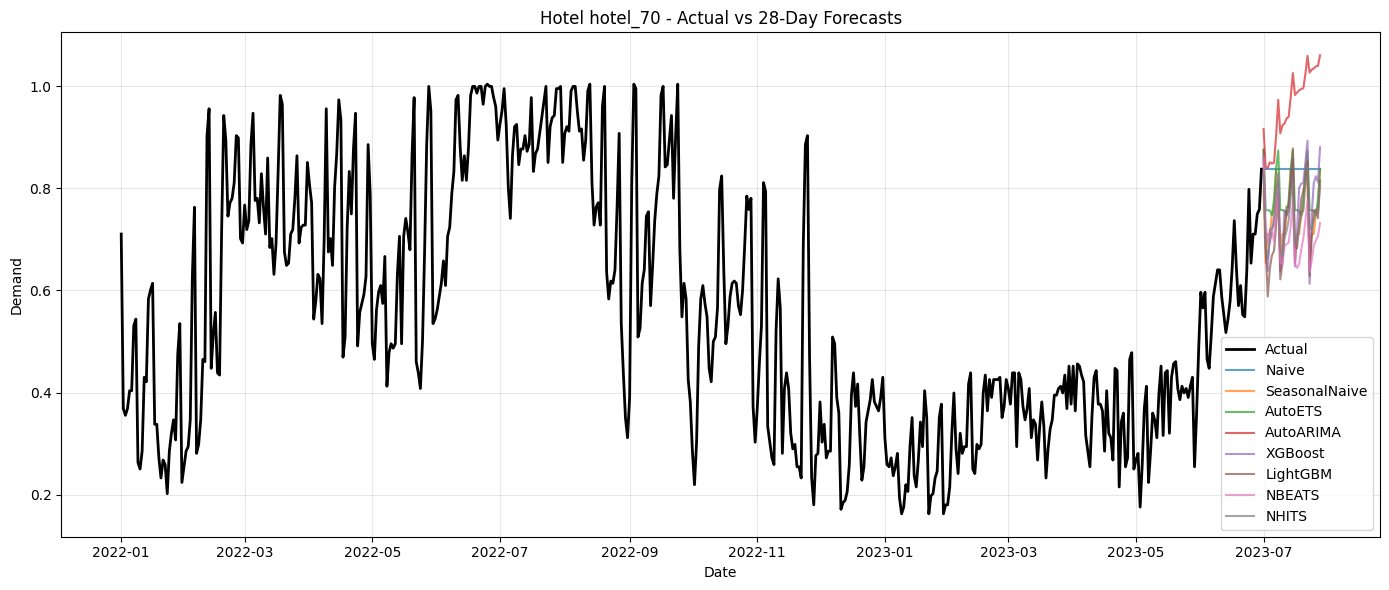

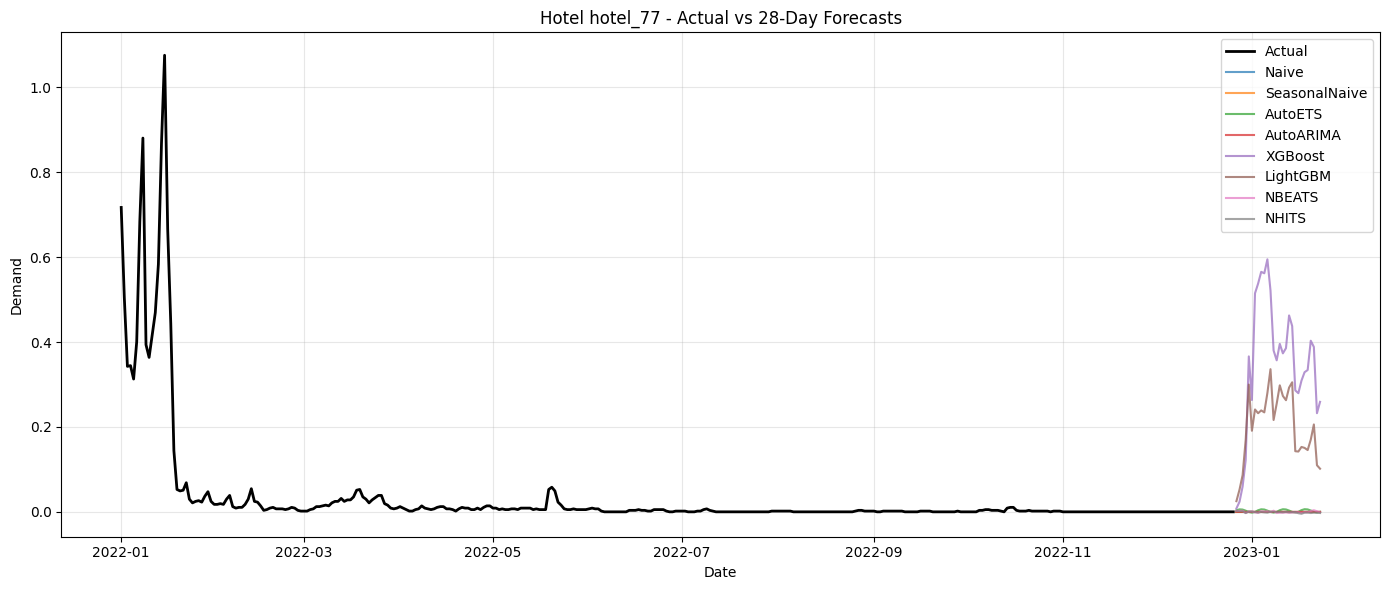

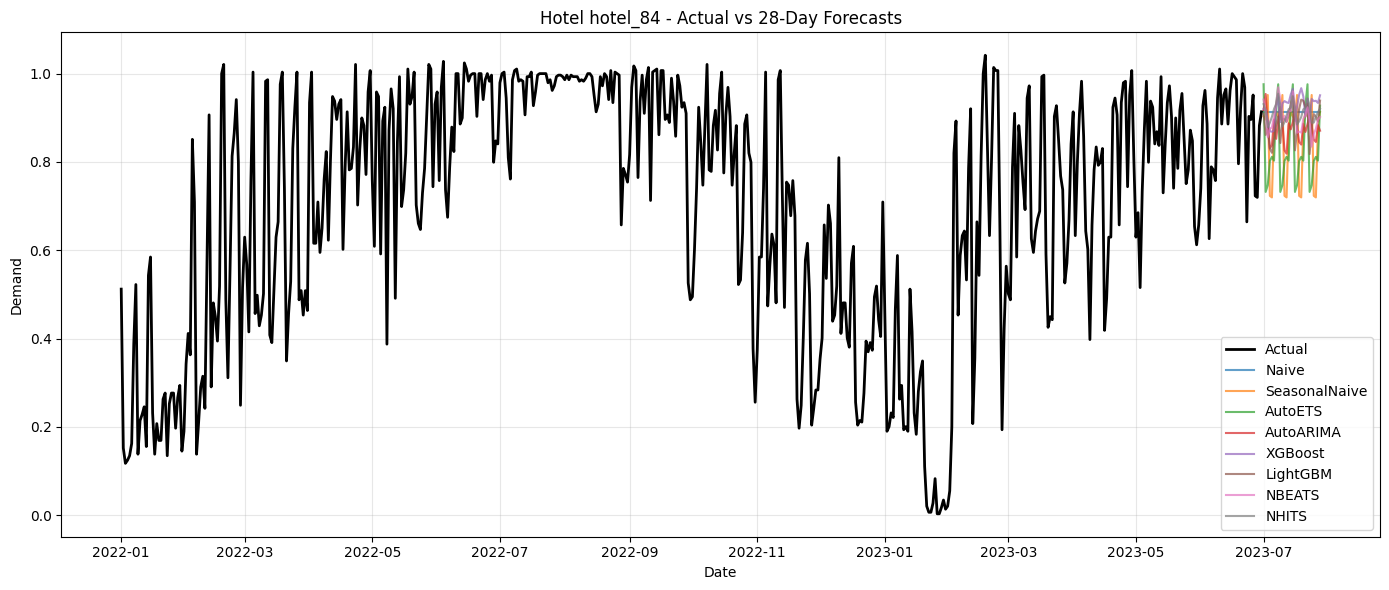

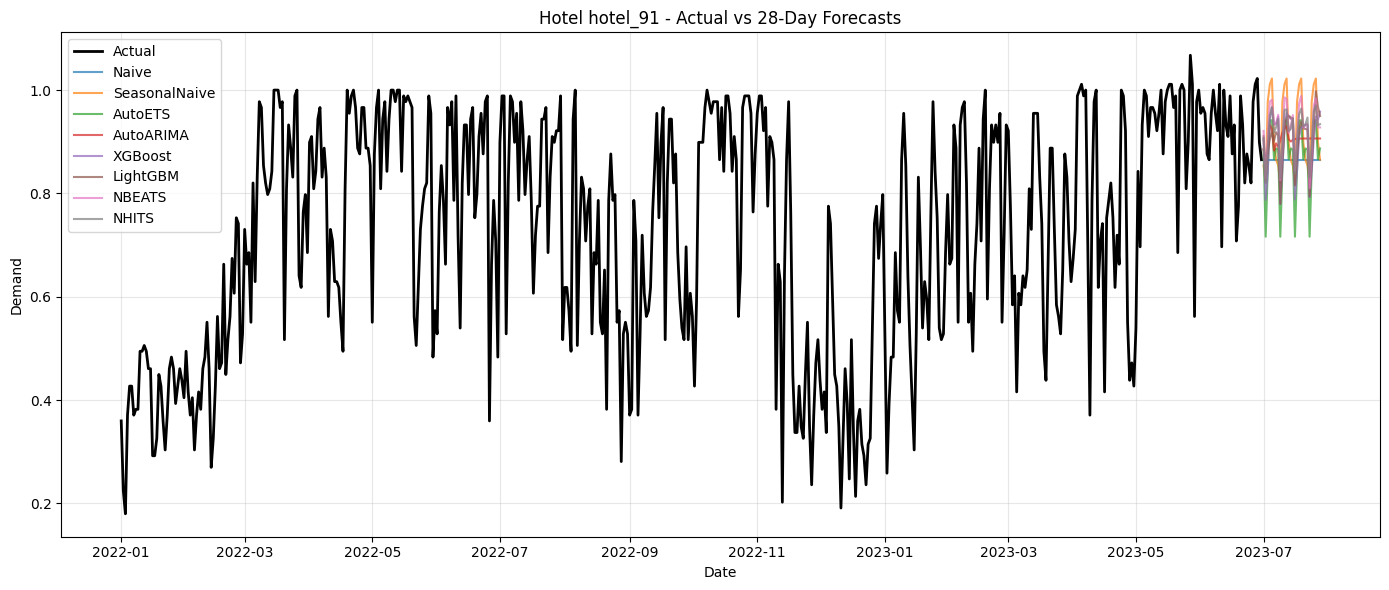

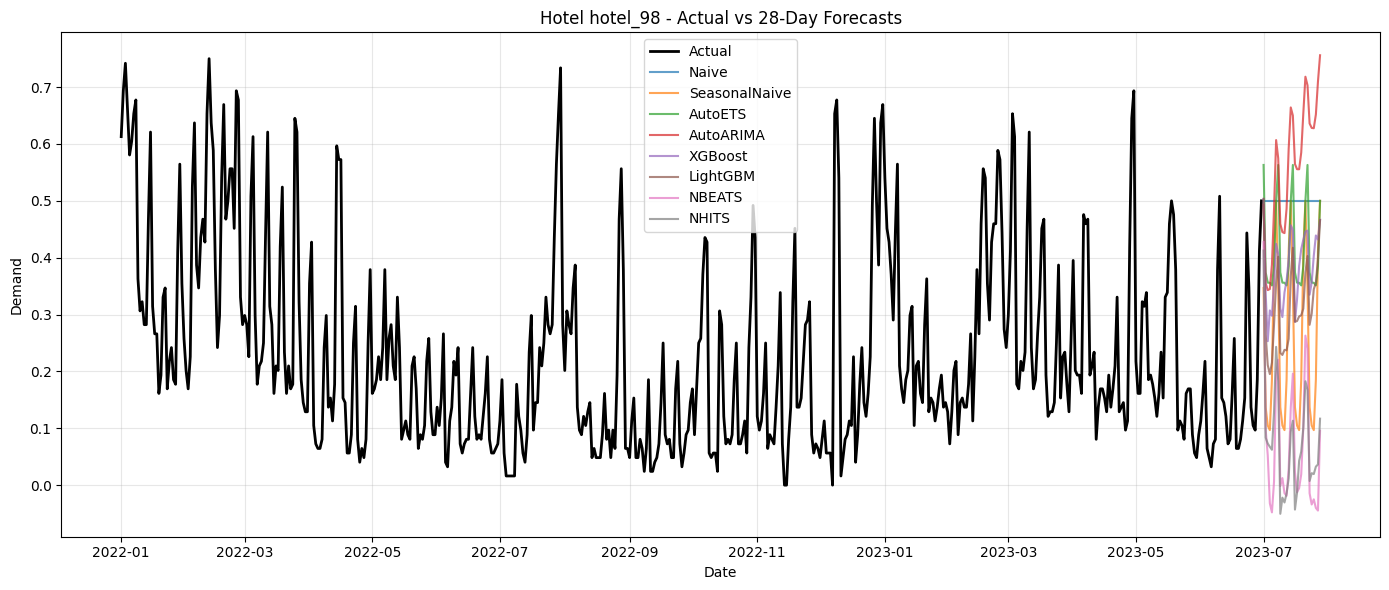

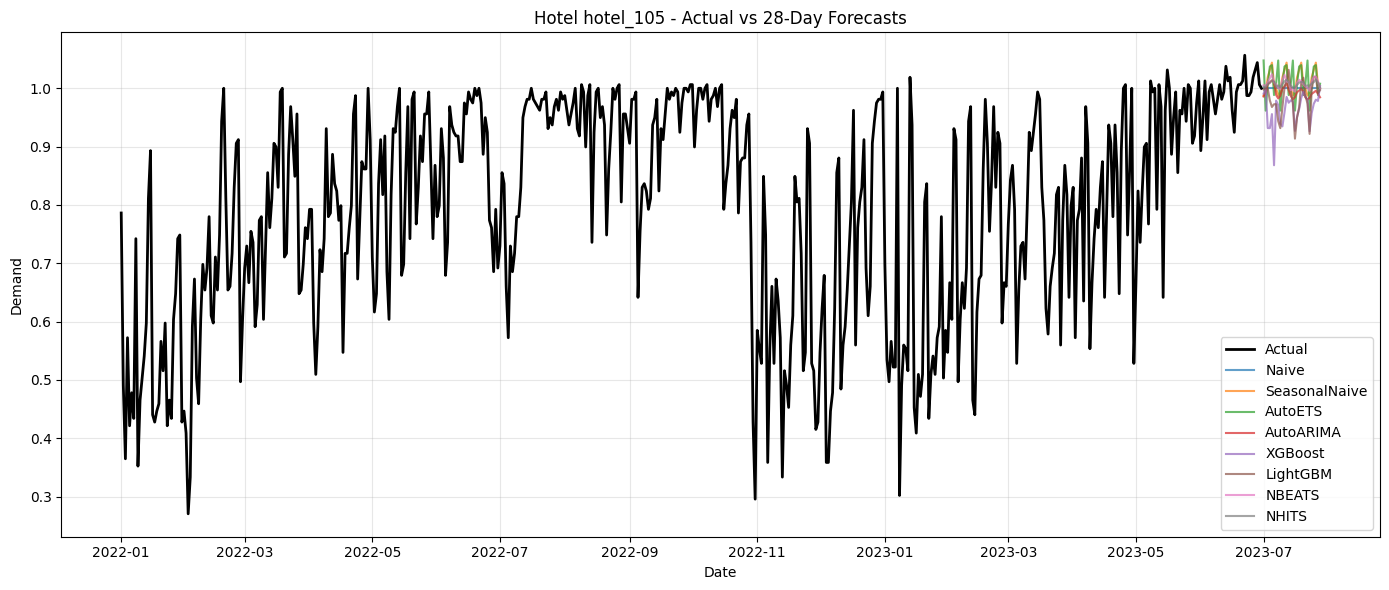

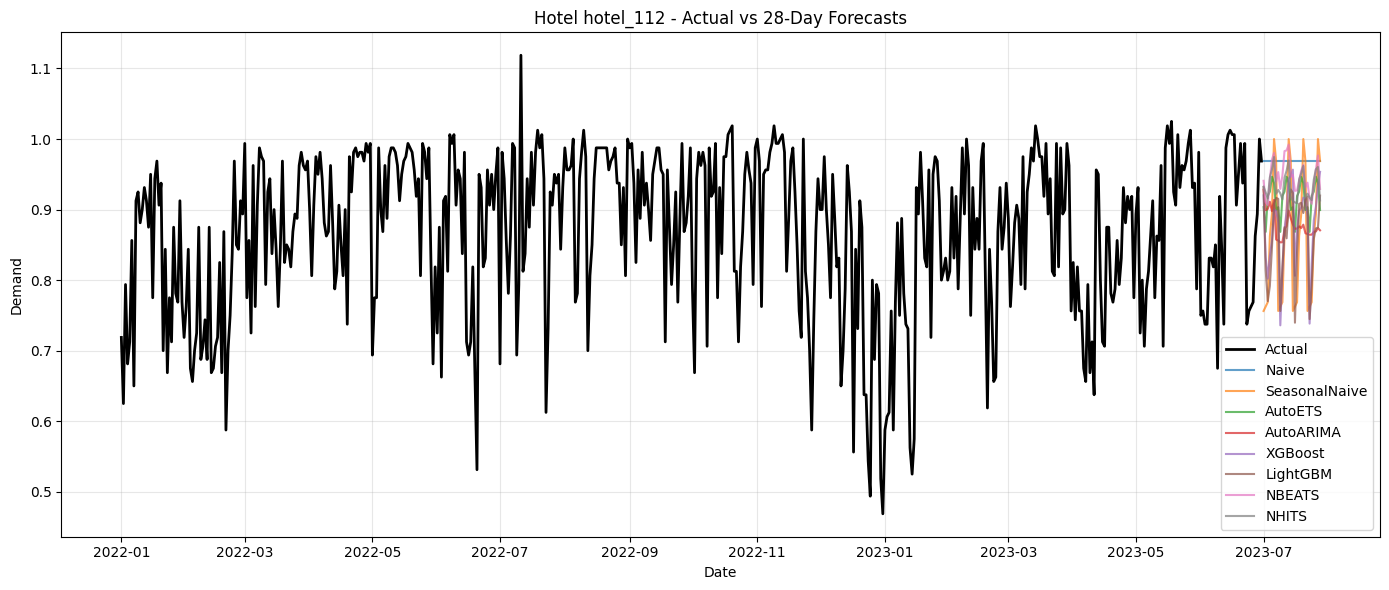

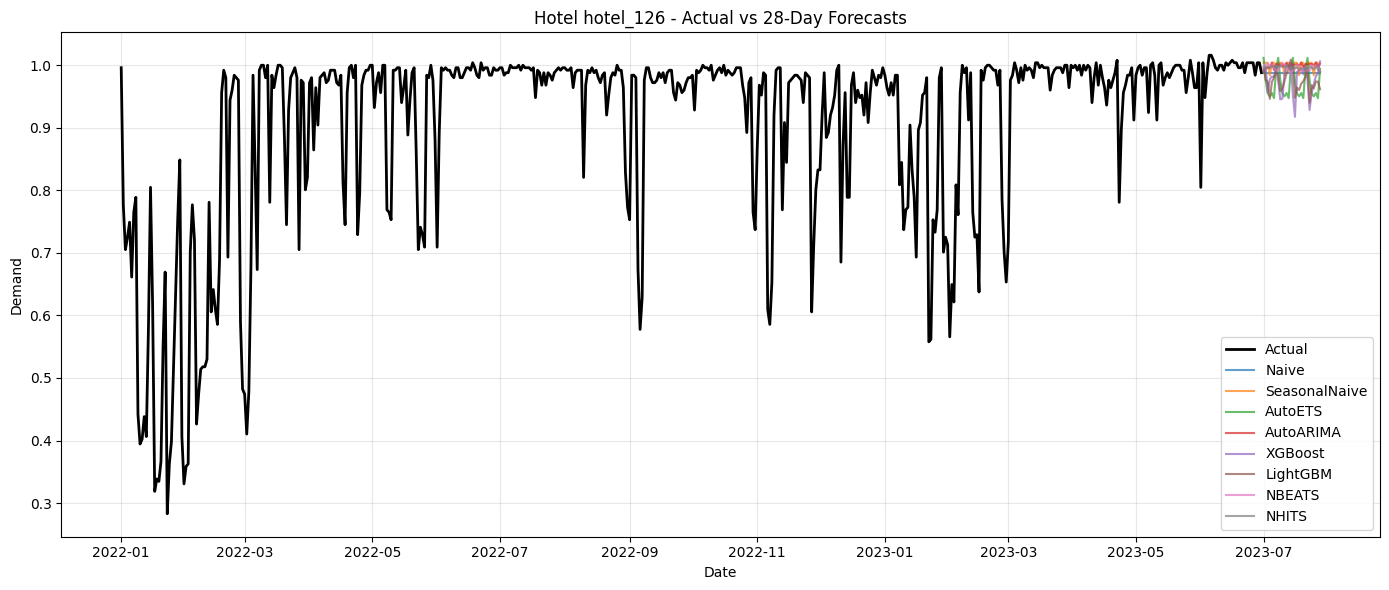

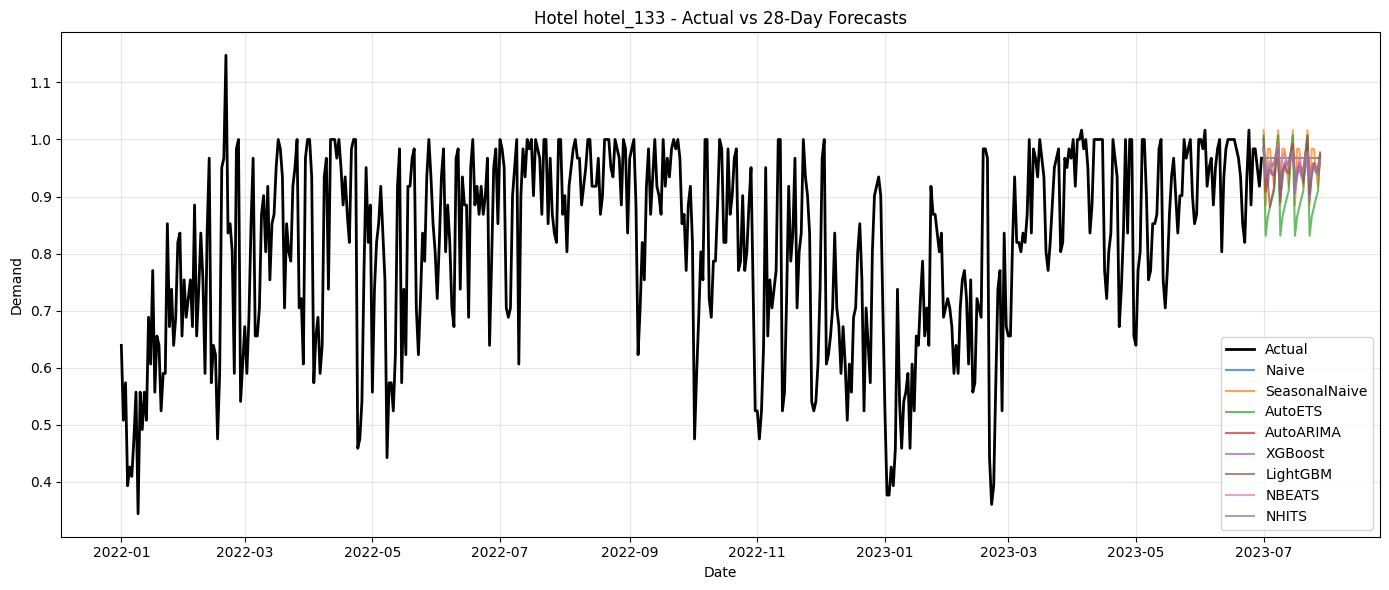

All forecast plots created and saved.


In [25]:
# 14) PLOTS FOR ALL HOTELS

print("Creating forecast plots for all hotels")

for hotel_id in hotels['unique_id'].unique():
    hist = hotels[hotels['unique_id'] == hotel_id]
    fcst = final_forecasts[final_forecasts['unique_id'] == hotel_id]

    plt.figure(figsize=(14, 6))
    plt.plot(hist['ds'], hist['y'], label='Actual', color='black', linewidth=2)

    for m in final_forecasts.columns:
        if m not in ['unique_id', 'ds', 'Naive', 'SeasonalNaive', 'AutoETS',
                     'AutoARIMA', 'XGBoost', 'LightGBM', 'NBEATS', 'NHITS', 'TimeGPT']:
            continue

    # explicit to avoid confusion
    for m in ['Naive', 'SeasonalNaive', 'AutoETS', 'AutoARIMA',
              'XGBoost', 'LightGBM', 'NBEATS', 'NHITS', 'TimeGPT']:
        if m in fcst.columns:
            plt.plot(fcst['ds'], fcst[m], label=m, alpha=0.7)

    plt.title(f"Hotel {hotel_id} - Actual vs 28-Day Forecasts")
    plt.xlabel("Date")
    plt.ylabel("Demand")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'forecast_plot_{hotel_id}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

print("All forecast plots created and saved.")

In [27]:
# 15) SUMMARY PRINT
print("PROJECT SUMMARY")
print(f"Dataset: 17 hotels, total observations: {len(hotels)}")
print(f"Forecast horizon: {H} days (4 weeks)")
print(f"Cross-validation folds: {N_WINDOWS} (non-overlapping)")
print("Models:")
print("  StatsForecast: Naive, SeasonalNaive, AutoETS, AutoARIMA")
print("  MLForecast: XGBoost, LightGBM")
print("  NeuralForecast: NBEATS, NHITS")
print("  TimeGPT")
print("\nMetrics: ME, MAE, RMSE, MAPE")
print("\nTop overall models by win count (lowest MAE):")
display(overall_wins.head(3))


PROJECT SUMMARY
Dataset: 17 hotels, total observations: 10172
Forecast horizon: 28 days (4 weeks)
Cross-validation folds: 5 (non-overlapping)
Models:
  StatsForecast: Naive, SeasonalNaive, AutoETS, AutoARIMA
  MLForecast: XGBoost, LightGBM
  NeuralForecast: NBEATS, NHITS
  TimeGPT

Metrics: ME, MAE, RMSE, MAPE

Top overall models by win count (lowest MAE):


win_count  count
0   chronos     19
1     NHITS     12
2  LightGBM     11